In [2]:
import numpy as np
from matplotlib import pylab as plt

In [60]:

def rowwise_normalize(X, power=2):
    power=np.clip(power, 0, 10)
    X2 = np.power(np.abs(X), power)
    return np.power((X2/np.sum(X2, axis=1)[:,np.newaxis]), 1.0/power)

rowwise_normalize(np.array([[2,2],[2,0]]), power=2)



array([[0.70710678, 0.70710678],
       [1.        , 0.        ]])

In [61]:
def sigmoid(x, xo, y_max, sl):
    return y_max/(1+ np.exp(-sl*(x-xo)))

In [62]:
def plot_Qs(prices,Q):
    for i in range(Q.shape[0]):
        plt.plot(prices, Q[i, :])


In [63]:
def delta_orthoginalize(X):
    I = np.eye(X.shape[0])
    D = I - np.dot(X, X.T)
    E = D * D
    DX = - 2 * np.dot(D, X)
    #print(f"D: {D}\nE: {E}")
    return DX

alpha = 0.01
X = np.array([[1.0, 0.1, 0.3],
              [0.1, 0.5, 0.1]])
for _ in range(100):
    DX = delta_orthoginalize(X)
    X = X - alpha * DX
print(f"X:{X}")


X:[[ 0.96166562 -0.00881931  0.27350171]
 [-0.01715152  0.96410111  0.1328283 ]]


In [64]:
from scipy.optimize import minimize

def smooth_by_sigmoid(Q):
    """
    Each row of Q consist of noisy samples from a sigmoid
    The least square minimal fitting version of sigmoid is souken
    and replaced in each row
    """
    
    x = np.arange(Q.shape[1])
    
    q_line = None
    def sigmoid_err(par):
        xo, y_max, sl = par
        y = sigmoid(x, xo, y_max, sl)
        err = q_line - y
        return np.sum(err * err)
    
    for i in range(Q.shape[0]):
        q_line = Q[i,:]
        par0 = [20, 1, -1]
        opt = minimize(sigmoid_err, par0)
        xo, y_max, sl = opt['x']
        Q[i,:] = sigmoid(x, xo, y_max, sl)
    return Q
        
#smooth_by_sigmoid(Qsens)

In [65]:
n_items = 10
n_bases = 5
n_users = 1000

# R ~= P x Q

Qtrue = np.abs(np.random.randn(n_bases, n_items)) # 5 bases and 10 features
Ptrue = np.random.rand(n_users, n_bases)   # non negative mixtures matrix
Ptrue = rowwise_normalize(Ptrue)

R = np.dot(Ptrue, Qtrue)

Qi = np.random.randn(n_bases, n_items) # 5 bases and 10 features

Pi = np.dot(R, np.linalg.pinv(Qi))
Qi = np.dot(np.linalg.pinv(Pi), R)

err = np.dot(Pi, Qi) - R
np.sum( err * err )


1.2416002350488023e-25

# Generate Q sens


In [66]:
# random price sensitivities

def gen_random_sigmoids(n_bases, n_prices, prices_upper_limit, balanced=False):
    
    slopes = -np.random.rand(n_bases)
    y_maxes = np.random.rand(n_bases) / 2 + 0.5
    if balanced:
        x_offsets = np.linspace(0, prices_upper_limit, n_bases+2)[1:-1]
    else:
        x_offsets = np.random.rand(n_bases) * prices_upper_limit
    x = np.linspace(0,prices_upper_limit, n_prices)

    Qsens = np.zeros((n_bases, n_prices))

    for inx, (sl, xo, ym) in enumerate(zip(slopes, x_offsets, y_maxes)):
        y = sigmoid(x, xo, ym, sl)
        Qsens[inx, :] = y
        
    return slopes, y_maxes, x_offsets, x, Qsens

n_prices = 20
prices_upper_limit = 50
slopes, y_maxes, x_offsets, prices, Qsens = gen_random_sigmoids(n_bases, 
                                                                n_prices=n_prices, 
                                                                prices_upper_limit=prices_upper_limit)

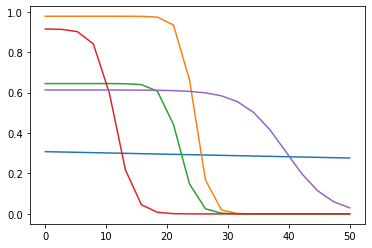

In [67]:
plot_Qs(prices, Qsens)

# Generate purchase samples in Rsens


In [68]:
Rsens = np.dot(Ptrue,  Qsens)

# generate offered price sampler
r = np.random.rand(n_users, n_prices)
m = np.dot(np.amax(r, axis=1)[:, np.newaxis], np.ones((1, n_prices))) 
#Msens = np.equal(m, r) # only one 1 is every row: this is the offered price

Msens = np.random.rand(*m.shape) < 0.08
#Msens = np.ones_like(Msens)

# sample at every price
Rpurchases = Rsens > np.random.rand(n_users, n_prices)

# select only the offered prices
Rpurch_at_price = (Rpurchases * Msens).astype(float)

Rext = np.concatenate([R, Rpurch_at_price], axis=1)
Mext = np.concatenate([np.ones_like(R), Msens], axis=1)

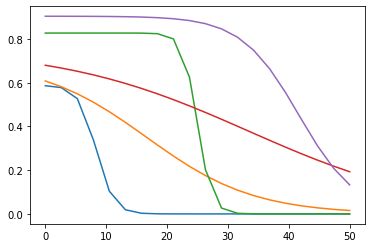

In [69]:
# initialization

Qi = np.random.randn(n_bases, n_items)

_, _, _, _, Qsensi = gen_random_sigmoids(n_bases, 
                                         n_prices=n_prices, 
                                         prices_upper_limit=prices_upper_limit,
                                         balanced=True)

plot_Qs(prices, Qsensi)

Qexti = np.concatenate([Qi, Qsensi], axis=1)


In [70]:
Pi = np.dot(Rext, np.linalg.pinv(Qexti))
Pi = rowwise_normalize(Pi)

In [71]:
PI = np.linalg.pinv(Pi)

z=np.dot(PI, Rpurch_at_price)  / np.dot(PI, M)

plot_Qs(prices, z)

NameError: name 'M' is not defined

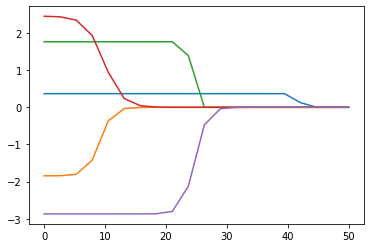

In [72]:
Pi = np.dot(Rext, np.linalg.pinv(Qexti))
Pi = rowwise_normalize(Pi)

Qexti = np.dot(np.linalg.pinv(Pi), Rext)
Qexti[:,n_items:] = smooth_by_sigmoid(Qexti[:,n_items:])
plot_Qs(prices, Qexti[:, n_items:])

# NMF

In [223]:
from sklearn.decomposition import NMF

In [224]:
clf=NMF(n_components=n_bases)

clf.fit(Rext)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=5)

# NMF:

Q = Q * (P' R) ./ (P' P Q)

P = P * (R Q) ./ (P Q Q')


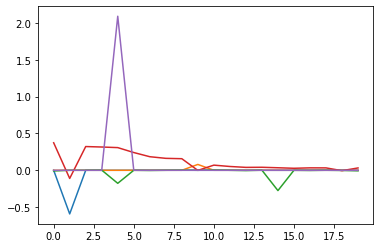

In [269]:
Qexti = Qexti * np.dot(np.transpose(Pi), Rext) / np.dot(np.transpose(P), np.dot(P, Qexti))
Pi = Pi * np.dot(Rext, np.transpose(Qexti)) / np.dot(np.dot(Pi, Qexti), np.transpose(Qexti))



In [439]:
Qtrue = np.abs(np.random.randn(n_bases, n_items)) # 5 bases and 10 features
Ptrue = np.random.rand(n_users, n_bases)   # non negative mixtures matrix
Ptrue = rowwise_normalize(Ptrue)

R = np.dot(Ptrue, Qtrue)

#Phat, Qhat = matrix_factorization(Rext, Pi, Qexti.T, n_bases, alpha=0.05, beta=0.02)
Phat, Qhat = matrix_factorization(R, Ptrue, Qtrue.T, n_bases, alpha=0.05, beta=0.02)


45.76017396796152
44.513805215708715
43.79238915010497
43.302626154196865
42.95039397621029
42.69156854816991
42.49917166767264
42.35592596324403
42.24884905419841
42.165410463922484
42.09927425401339
42.04661152421191
42.005012800353114
41.9719332687
41.94412788523895
41.92151320821669
41.90238210720587
41.88616056304469
41.87207414008593
41.85990022807577
41.84918104840514
41.839172727246286
41.82998270065726
41.821390267010436
41.81329404377084
41.80567019885555
41.79836575843248
41.79143641081812
41.784735909561405
41.778336027614685
41.77205774092426
41.76603132474327
41.760138442131996
41.754446561047644
41.7488681307992
41.7434560694842
41.738142942690786
41.73293988164353
41.72782265313338
41.722828813193885
41.7179217494933
41.71340400186055
41.70877940963422
41.704335513617764
41.69989857345878
41.695583722329175
41.691323963887676
41.68714872311877
41.68302287578354
41.67906774692878
41.67510202706215
41.67129301868908
41.667479119201374
41.66379947321597
41.6601210782359
41

41.45554896382299
41.455932713875946
41.45629876265834
41.45668267282192
41.457049642417466
41.45743363548139
41.45780137989425
41.45818538092225
41.458553767292486
41.458946411320596
41.45933037132232
41.45973365659666
41.46012550240824
41.460533691014554
41.46092929810832
41.46133946191414
41.461736651152165
41.4621472121898
41.46254477151355
41.46295483701291
41.46335205582844
41.46376109522946
41.464157534385684
41.46456521691498
41.4649605908327
41.46536670066456
41.46576081444404
41.466165204538065
41.46655791894651
41.46696048486998
41.467351696024345
41.46775236052091
41.46814198764045
41.468540691213036
41.46892866899331
41.46932536399537
41.4697116377231
41.470106284557886
41.47049080691355
41.47088337154326
41.47126610046963
41.47165655275879
41.47203745001174
41.47242782616775
41.47276353845639
41.47312296802989
41.47346260195052
41.47381512305744
41.47415480022594
41.474503309645215
41.47484187742808
41.475187626068966
41.47552474431871
41.4758682976586
41.476203899604215


41.64060282687119
41.64080801856584
41.64100689726947
41.64119951814655
41.641385979541006
41.64156635060245
41.64174071338558
41.64190914452095
41.6420717155769
41.642228506446095
41.642379582019196
41.64252502277806
41.64266488939439
41.64279926129986
41.64292819650068
41.64305177242661
41.643170045369715
41.643283090252616
41.64339096221208
41.643487003409845
41.64357256969837
41.64364881311813
41.64371667226049
41.64377690171161
41.643830116522146
41.64387682257866
41.643917432176295
41.64395229236024
41.643981687009656
41.644005860718764
41.64402501505746
41.64403932785282
41.644048947290706
41.6440540072245
41.644054620820484
41.6440508926493
41.644042912638454
41.64408876306827
41.64409762706589
41.64412274521157
41.64412205157826
41.64413159838666
41.64413111131593
41.644137342325934
41.64413182294367
41.64412977635011
41.64411874502458
41.644108638099
41.644091413283086
41.644073510923626
41.64404975436578
41.644024331385395
41.643993911359445
41.64396122501222
41.643924130351

41.576924436645584
41.576918846476964
41.57691468402288
41.57691191016174
41.57691055822952
41.576910603314154
41.57691206697069
41.5769149334915
41.5769192166566
41.57692490665989
41.57693201214531
41.57694052703546
41.57695045657181
41.57696179698033
41.57697455123749
41.57698871694174
41.577004295546814
41.577021285420784
41.577039686978125
41.57705949896889
41.57708072108151
41.57710735774006
41.577142195260265
41.57714200960641
41.57716794314991
41.57717876117244
41.57718541676785
41.57718549832043
41.577181036735674
41.57717325151639
41.577163358227864
41.57715211389011
41.57714025851394
41.57712825471897
41.57711655562625
41.57710544144662
41.57709519174716
41.57708597512784
41.57707796522834
41.57707126258716
41.57706597542792
41.577062162736475
41.57705989181753
41.577059196201496
41.57706011725901
41.57707104364582
41.57707827242941
41.577092903179285
41.577104976848666
41.57712333984938
41.577140043375294
41.57716213315154
41.5771832751991
41.577209080764085
41.5772345023676

41.711845730627765
41.71217685972107
41.7125065002066
41.712836157277756
41.71316447721878
41.71349268014318
41.71381966374724
41.71414641103663
41.71447203187853
41.714798651890035
41.715128378895066
41.71546115011602
41.715795760152005
41.71613225848783
41.716469801553906
41.71681035955762
41.717161425349545
41.717521210443216
41.71788728488937
41.718258684553284
41.71863392432892
41.71901249092525
41.71939344382834
41.71977650755311
41.72016106692767
41.720546974012365
41.720933814516094
41.721321509429394
41.72170977209839
41.722098560652576
41.72248767163333
41.72287883050969
41.7232771767871
41.72368175000497
41.72409153060196
41.72450587615766
41.72492413943105
41.725345904164755
41.72577073857733
41.72619835977278
41.72662846753036
41.727060862082844
41.727495327339
41.7279317171968
41.72836987106678
41.72880967829448
41.72925101577385
41.729693796711345
41.73013792385995
41.73058332682309
41.73102992660146
41.73147766435868
41.731926474308764
41.73237630602792
41.7328271035781

KeyboardInterrupt: 

In [73]:
def add_new_col(X, new_col=None):
    m = np.zeros((X.shape[0],X.shape[1]+1)); 
    m[:,:-1] = X
    if new_col is not None:
        m[:,-1] = new_col
    return m

def add_new_row(X, new_row=None):
    m = np.zeros((X.shape[0]+1,X.shape[1])); 
    m[:-1,:] = X
    if new_row is not None:
        m[-1,:] = new_row
    return m
        
add_new_col(P, new_col=np.random.rand(R.shape[0])).shape

NameError: name 'P' is not defined

In [52]:
# R ~= P x Q + p_bias + q_bias + mu

class MatrixFactorization:
    """
        L = \sum_ij  Mask_ij x (R  -  (P x Q))_ij

        P*, Q* = argmin_{P,Q} L  +  beta ||P||_2 + beta ||Q||_2

    alpha: is the SGD learning rate

    if add_bias is set then

           P*, Q* = argmin_{P,Q} L + p_bias_i + q_bias_j +  beta ||P||_2 + beta ||Q||_2

    if item_importance_vector is used then columns are weighted by the correspoding 
    vector entry

    error_delta_limit - iteration stops if loss doesn't decrease at least by this value


    """
    def __init__(self,
                 factors = 5, 
                 iterations = 1000, 
                 alpha = 0.0005, 
                 beta = 0.02, 
                 Pinit=None, 
                 Qinit=None,
                 add_bias=False,
                 p_modifier=lambda x:x, 
                 q_modifier=lambda x:x,
                 item_importance_vector=None, 
                 error_delta_limit=0.3):
        
       self.factors = factors
       self.iterations = iterations
       self.alpha = alpha
       self.beta = beta 
       self.Pinit = Pinit
       self.Qinit = Qinit
       self.add_bias = add_bias
       self.p_modifier = p_modifier
       self.q_modifier = q_modifier
       self.item_importance_vector = item_importance_vector
       self.error_delta_limit = error_delta_limit

    def fit(self, R, M):
        """
            R - rating matrix
            M - mask. M_ij = 1 - if R_ij is valid
        """
        M = np.ones_like(R) if M is None else M

        P = np.random.randn(R.shape[0], self.factors) if Pinit is None else self.Pinit
        Q = np.random.randn(self.factors, R.shape[1]) if Qinit is None else self.Qinit

        if self.add_bias:
            P = add_new_col(P, new_col=1)
            P = add_new_col(P, new_col=np.random.rand(R.shape[0]))
            Q = add_new_row(Q, new_row=np.random.rand(R.shape[1]))
            Q = add_new_row(Q, new_row=1)

        v = np.ones(R.shape[1]) if self.item_importance_vector is None else self.item_importance_vector
        W = np.diag(v)

        errors = []
        prev_error = np.inf
        for iteration in range(self.iterations):

            R_hat = np.dot(P, Q)
            D = (R - R_hat) * M
            E = (D*D).sum()
            print(f"{iteration}. error: {E}")
            
            Dw = np.dot(D, W)
            
            DP = - 2 * (np.dot(Dw, Q.T) - self.beta * P)
            P = P - self.alpha * DP
            
            DQ = - 2 * (np.dot(P.T, Dw) - self.beta * Q)
            Q = Q - self.alpha * DQ

            if self.add_bias:
                P[:,-2] = 1
            P = self.p_modifier(P)

            if self.add_bias:
                Q[-1,:] = 1
            Q = self.q_modifier(Q)

            if error > prev_error - self.error_delta_limit:
                print("error decrease not fast enough! Change alpha or beta")
                break
            prev_error = error
            errors.append(error)

        if self.add_bias:
            self.P = P[:,:-2]
            self.p_bias = P[:,-1]
            
            self.Q = Q[:-2,:]
            self.q_bias = Q[-2,:]
        else:
            self.P = P
            self.Q = Q

        self.errors = errors
        
    def predict_missing(self, R, M):
        """
            R - rating matrix
            M - mask. M_ij = 1 - if R_ij is valid
        """
        M = np.ones_like(R) if M is None else M

        P = np.random.randn(R.shape[0], self.factors) if Pinit is None else self.Pinit
        Q = np.random.randn(self.factors, R.shape[1]) if Qinit is None else self.Qinit

        if self.add_bias:
            P = add_new_col(P, new_col=1)
            P = add_new_col(P, new_col=np.random.rand(R.shape[0]))
            Q = add_new_row(Q, new_row=np.random.rand(R.shape[1]))
            Q = add_new_row(Q, new_row=1)

        v = np.ones(R.shape[1]) if self.item_importance_vector is None else self.item_importance_vector
        W = np.diag(v)

        errors = []
        prev_error = np.inf
        for iteration in range(self.iterations):

            R_hat = np.dot(P, Q)
            D = (R - R_hat) * M
            E = (D*D).sum()
            print(f"{iteration}. error: {E}")
            
            Dw = np.dot(D, W)
            
            DP = - 2 * (np.dot(Dw, Q.T) - self.beta * P)
            P = P - self.alpha * DP

            if self.add_bias:
                P[:,-2] = 1
            P = self.p_modifier(P)

            if error > prev_error - self.error_delta_limit:
                print("error decrease not fast enough! Change alpha or beta")
                break
            prev_error = error
            errors.append(error)            

        self.errors = errors, R_hat


In [53]:
clf = MatrixFactorization(p_modifier=rowwise_normalize,
                  error_delta_limit=0.01,
                  beta=0,
                  add_bias=False)


clf.fit(Rext, Mext)

#errors_, P_, Q_ 

plt.plot(clf.errors)
plt.figure()
plot_Qs(prices, clf.Q[:,n_items:])

NameError: name 'Rext' is not defined

0. error: 60618.085803416085
1. error: 5089.924563954076
2. error: 3494.1883834670593
3. error: 2469.2799537137826
4. error: 1812.8052797315702
5. error: 1392.6219818164952
6. error: 1123.4792912333407
7. error: 950.7357953403819
8. error: 839.4933045384638
9. error: 767.4967819737817
10. error: 720.5616435621232
11. error: 689.6453003764699
12. error: 668.9817622714119
13. error: 654.8913030519326
14. error: 645.0250406870751
15. error: 637.8816273378159
16. error: 632.5205761130475
17. error: 628.3458005958672
18. error: 624.8859274456385
19. error: 621.9093941733167
20. error: 619.2658440215982
21. error: 616.8554160523174
22. error: 614.619600126807
23. error: 612.5246685359836
24. error: 610.5245743697706
25. error: 608.5992003982188
26. error: 606.7402121124089
27. error: 604.9368832973281
28. error: 603.1925472786986
29. error: 601.4971896962486
30. error: 599.8463291047304
31. error: 598.2355267587305
32. error: 596.6646014312915
33. error: 595.1306827859219
34. error: 593.6340

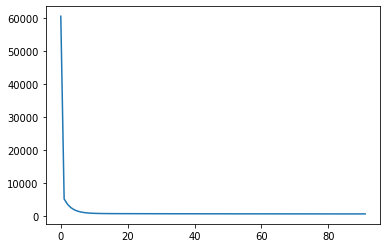

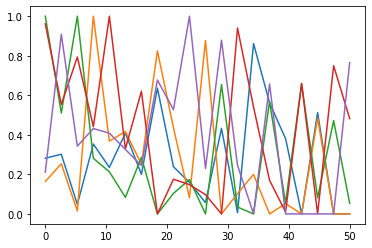

In [331]:
def q_modifier(Q):
    # Non bias version only
    return np.clip(Q, 0, 1)

clf = MatrixFactorization( 
               p_modifier=rowwise_normalize, 
               q_modifier=q_modifier,
               beta = 0,
               error_delta_limit=0.5)

clf.fit(Rext, Mext)

plt.plot(clf.errors)
plt.figure()
plot_Qs(prices, clf.Q[:,n_items:])

0. error: 62641.68883675588
1. error: 2916.4982207416656
2. error: 1497.5505282757401
3. error: 980.4386419037236
4. error: 773.7445675707941
5. error: 685.9878743532169
6. error: 642.6924258531163
7. error: 619.976100315918
8. error: 606.9839801040947
9. error: 598.9326266076889
10. error: 593.4755585474304
11. error: 589.4205076365103
12. error: 586.172773805494
13. error: 583.4259900124505
14. error: 581.0144651032018
15. error: 578.8398465025483
16. error: 576.8519356944773
17. error: 575.015177291836
18. error: 573.3159643727831
19. error: 571.7285726964557
20. error: 570.2540292935814
21. error: 568.8689827271219
22. error: 567.5791662587965
23. error: 566.3650897010026
24. error: 565.2290263165349
25. error: 564.1569054191503
26. error: 563.1496303696869
27. error: 562.1963449003699
28. error: 561.2985067108611
29. error: 560.4448203479359
30. error: 559.6370130807124
31. error: 558.8685775416673
32. error: 558.137513338871
33. error: 557.4426242073712
34. error: 556.77995351248

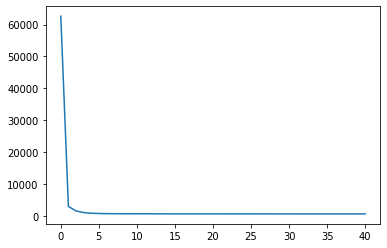

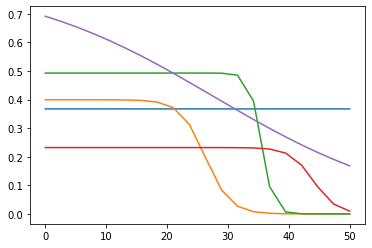

In [339]:
def q_modifier(Q):
    Q = np.clip(Q, 0, 1.0)
    Q[:,n_items:] = smooth_by_sigmoid(Q[:,n_items:])
    return Q


clf = MatrixFactorization( 
               alpha=0.001,
               beta=0,
               p_modifier=rowwise_normalize, 
               q_modifier=q_modifier, 
               error_delta_limit=0.5)

clf.fit(Rext, Mext)

plt.plot(clf.errors)
plt.figure()
plot_Qs(prices, clf.Q[:,n_items:])


Text(0.5, 1.0, 'Reconstructed')

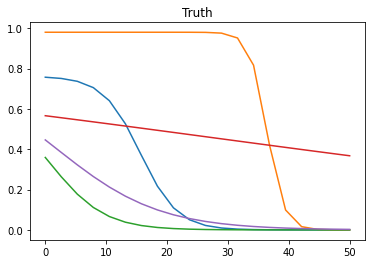

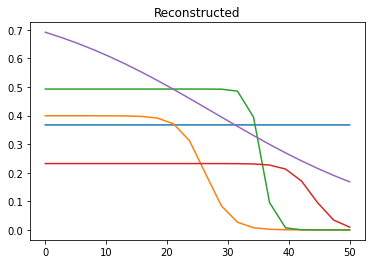

In [340]:
plot_Qs(prices, Qsens)
plt.title('Truth')

plt.figure()

plot_Qs(prices, clf.Q[:,n_items:])
plt.title("Reconstructed")


0. error: 71097.28454573105
1. error: 5149.996436496451
2. error: 3494.0285706018053
3. error: 2430.947035573061
4. error: 1750.931941067793
5. error: 1316.6853727966213
6. error: 1039.506165934595
7. error: 862.5319572076703
8. error: 749.4521457767951
9. error: 677.117408433729
10. error: 630.7777952176954
11. error: 601.0388733638321
12. error: 581.8988922695526
13. error: 569.5330237170526
14. error: 561.4981767307843
15. error: 556.2289747408912
16. error: 552.7309420539901
17. error: 550.3610678585753
18. error: 548.7134835561073
19. error: 547.5265764987334
20. error: 546.6430269084285
21. error: 545.9342836159802
22. error: 545.3355287492413
23. error: 544.7963437181153
24. error: 544.3000330344228
error decrease not fast enough! Change alpha or beta


Text(0.5, 1.0, 'Reconstructed')

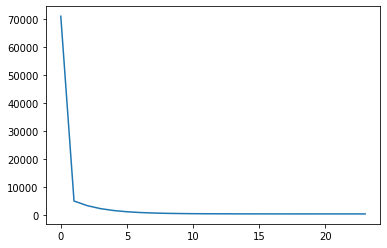

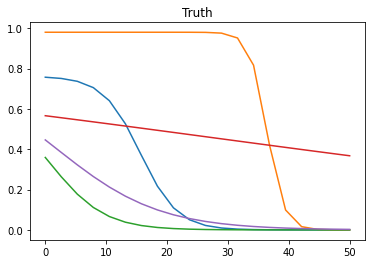

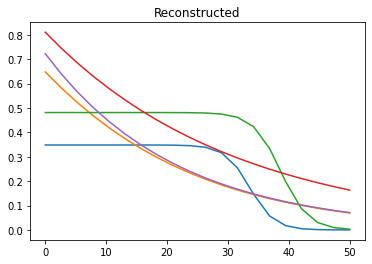

In [350]:
item_importance_vector = np.array([1] * n_items + [10] * n_prices)

clf = MatrixFactorization( 
               q_modifier=q_modifier,
               p_modifier=rowwise_normalize,
               error_delta_limit=0.5, 
               item_importance_vector=item_importance_vector)

clf.fit(Rext, Mext)

plt.plot(clf.errors)
plt.figure()

plot_Qs(prices, Qsens)
plt.title('Truth')

plt.figure()

plot_Qs(prices, clf.Q[:,n_items:])
plt.title("Reconstructed")
